In [1]:
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

## Get Data

In [2]:
# set the start and end dates of the desired financial data
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,1,1)

#tickers is a dictionary of the desired crypto currenceies and their yahoo tickers
tickers = {'Bitcoin':'BTC-USD', 'Bitcoin Cash':'BCH-USD',
                 'Ethereum':'ETH-USD','Litecoin':'LTC-USD',
                 'Tron':'TRX-USD',
                 'Binance Coin':'BNB-USD',
                 'Ripple':'XRP-USD','Cardano':'ADA-USD',
                 'Stellar':'XLM-USD','Monero':'XMR-USD',
                  'Chainlink':'LINK-USD','Dogecoin':'DOGE-USD', 
                   'Polkadot':'DOT1-USD'}

In [3]:
# the code below downloads the desired data
def get_data(tickers, start, end):
    crypto_prices = web.DataReader(list(tickers.values())[0], 'yahoo', start, end).reset_index()[['Date','Close']]
    crypto_volume = web.DataReader(list(tickers.values())[0], 'yahoo', start, end).reset_index()[['Date','Volume']]
    for ticker in list(tickers.values())[1:]:
        data = web.DataReader(ticker, 'yahoo', start, end).reset_index()
#         price = web.DataReader(ticker, 'yahoo', start, end).reset_index()[['Date','Close']]
        price = data[['Date','Close']]
        volume = data[['Date','Volume']]
        crypto_prices = crypto_prices.merge(price, left_on='Date', right_on='Date', how='outer')
        crypto_volume = crypto_volume.merge(volume, left_on='Date', right_on='Date', how='outer')
    crypto_prices = crypto_prices.set_index('Date')
    crypto_prices.columns = list(tickers.keys())
    crypto_volume = crypto_volume.set_index('Date')
    crypto_volume.columns = list(tickers.keys())
    return crypto_prices, crypto_volume 

prices, volume = get_data(tickers, start, end)

## Data Exploration

In [4]:
moving30 =  prices.rolling(window=30).mean()
moving90 = prices.rolling(window=90).mean()
daily_pc = prices.pct_change(1)
returns = prices/prices.shift(1)
log_ret = np.log(returns)
corr = log_ret.corr()

In [5]:
prices.pct_change(1).corr()

,Bitcoin,Bitcoin Cash,Ethereum,Litecoin,Tron,Binance Coin,Ripple,Cardano,Stellar,Monero,Chainlink,Dogecoin,Polkadot
Bitcoin,1.000000,0.530345,0.480691,0.610561,0.455445,0.513206,0.311250,0.413939,0.335809,0.325819,0.163277,0.115551,0.238777
Bitcoin Cash,0.530345,1.000000,0.617718,0.558895,0.336386,0.354292,0.415459,0.351373,0.323476,0.260667,0.140245,0.072244,0.232680
Ethereum,0.480691,0.617718,1.000000,0.453032,0.488714,0.482538,0.264360,0.470702,0.271045,0.255740,0.202084,0.079318,0.302687
Litecoin,0.610561,0.558895,0.453032,1.000000,0.414372,0.451125,0.347019,0.418139,0.331091,0.265109,0.155270,0.109109,0.224782
Tron,0.455445,0.336386,0.488714,0.414372,1.000000,0.347926,0.397006,0.370834,0.290840,0.187390,0.138531,0.069927,0.213927
Binance Coin,0.513206,0.354292,0.482538,0.451125,0.347926,1.000000,0.286581,0.334191,0.273145,0.195767,0.146110,0.066002,0.206597
Ripple,0.311250,0.415459,0.264360,0.347019,0.397006,0.286581,1.000000,0.457539,0.468322,0.164997,0.137615,0.092371,0.174252
Cardano,0.413939,0.351373,0.470702,0.418139,0.370834,0.334191,0.457539,1.000000,0.416694,0.208463,0.124321,0.070960,0.313114
Stellar,0.335809,0.323476,0.271045,0.331091,0.290840,0.273145,0.468322,0.416694,1.000000,0.199014,0.132860,0.093095,0.150410
Monero,0.325819,0.260667,0.255740,0.265109,0.187390,0.195767,0.164997,0.208463,0.199014,1.000000,0.072444,0.042897,0.226860


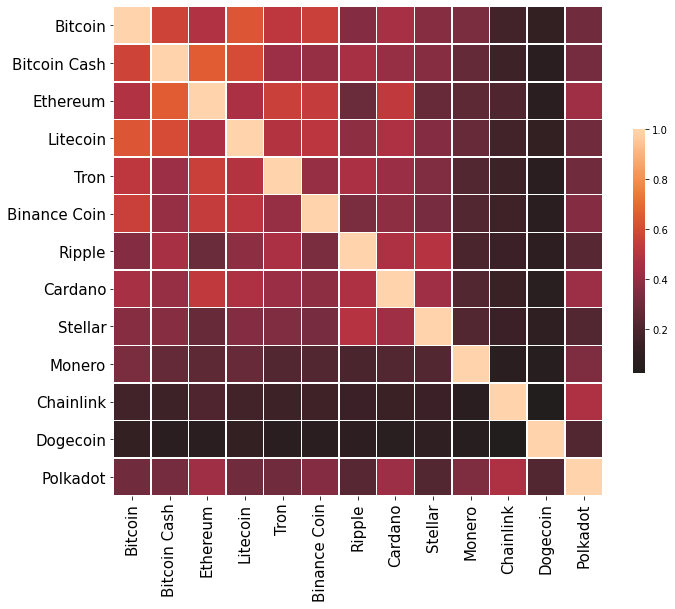

In [6]:
fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr,cbar_kws={"shrink": .5},linewidths=.5,square=True, center=0 )
ax.tick_params(labelsize=15)

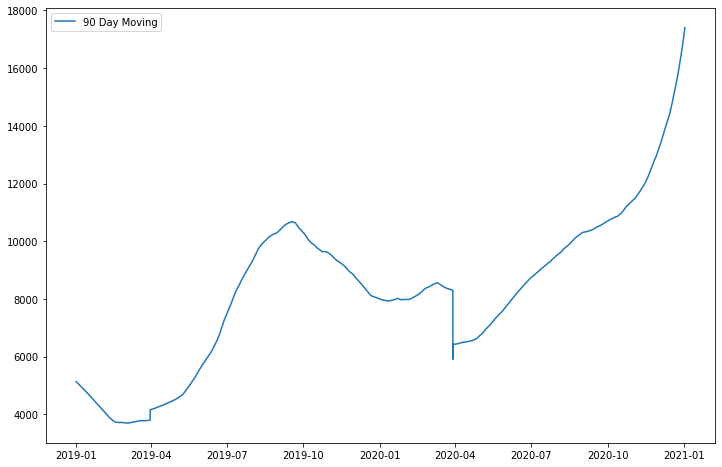

In [7]:
plt.figure(figsize=(12,8))
# plt.plot(moving30.loc['2019':]['Bitcoin'], label='30 Day Moving')
plt.plot(moving90.loc['2019':]['Bitcoin'], label='90 Day Moving')
# plt.plot(prices.loc['2019':]['Bitcoin'], label='Price')
plt.legend()

## Monte Carlo Simulation

In [10]:
def monte_carlo(log_ret, n_portfolios=5000):
    n_currencies = log_ret.shape[1]
    # Mean Log Return
    mean_log_ret = log_ret.mean()
    # Covariance Matrix
    sigma = log_ret.cov()
    # Weight Matrix
    all_weights = np.zeros((n_portfolios,n_currencies))
    # Expected Return array
    ret_arr = np.zeros(n_portfolios)
    # Expected Volatility array
    vol_arr = np.zeros(n_portfolios)
    # Sharpe Ratio array
    sharpe_arr = np.zeros(n_portfolios) 
    
    for k in range(n_portfolios):
        # Weights
        weights = np.array(np.random.random(n_currencies))
        weights = weights/np.sum(weights)
        # Save Weights
        all_weights[k,:] = weights
        # Expected Log Returns
        ret_arr[k] = np.sum(mean_log_ret * weights * 356)
        # expected volatility
        vol_arr[k] = np.sqrt(np.dot(weights.T, np.dot(sigma*365,weights)))
        #sharpe ratio
        sharpe_arr[k] = ret_arr[k]/vol_arr[k]
            
    return ret_arr, vol_arr, sharpe_arr, all_weights
 

In [11]:
ret_arr, vol_arr, sharpe_arr, best_weights = monte_carlo(log_ret, n_portfolios=5000)
max_index = sharpe_arr.argmax()

In [12]:
best_weights[max_index]

array([0.16250275, 0.04277553, 0.08606448, 0.00250826, 0.05410442,
       0.09502362, 0.00561275, 0.08160517, 0.00113041, 0.20148021,
       0.0244451 , 0.03157317, 0.21117413])

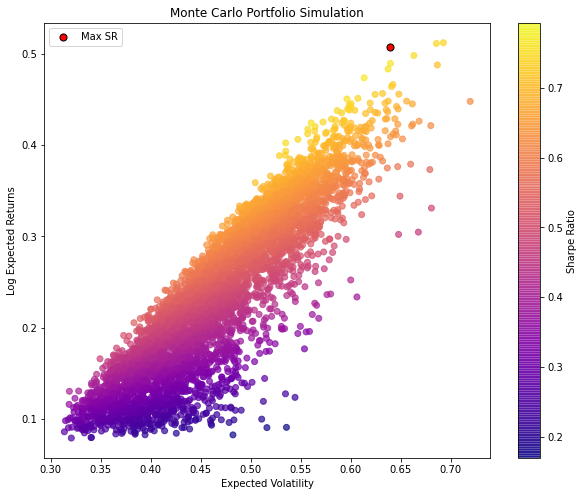

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=.7)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_arr[max_index], 
            ret_arr[max_index], c='red', s=50, edgecolors='black', label='Max SR')
plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.title('Monte Carlo Portfolio Simulation')
plt.legend()

## Optimization

In [15]:
def get_ret_vol_sr(weights):
    # Mean Log Return
    mean_log_ret = log_ret.mean()
    # Covariance Matrix
    sigma = log_ret.cov()
    
    weights = np.array(weights)
    ret = np.sum(mean_log_ret * weights) * 356
    vol = np.sqrt(np.dot(weights.T, np.dot(sigma*356, weights)))
    sr = ret/vol
    
    return np.array([ret,vol,sr])

In [16]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [17]:
def check_sum(weights):
    # returns 0 if sum of the weights is 1
    return np.sum(weights) - 1 

In [18]:
n_currencies = prices.shape[1]
constraints = ({'type':'eq','fun':check_sum})
bounds = tuple([(0,1) for i in range(n_currencies)])
x0 = [1/n_currencies for i in range(n_currencies)]

In [19]:
options={'disp':True, 'return_all':True}

In [20]:
opt_results = minimize(neg_sharpe, x0, method='SLSQP', 
                       bounds=bounds, constraints=constraints)

In [35]:
opt_weights = list(opt_results.x)

In [36]:
[round(i,3) for i in opt_weights]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [22]:
get_ret_vol_sr(opt_results.x)

array([1.9927629 , 1.99328507, 0.99973804])

<BarContainer object of 13 artists>

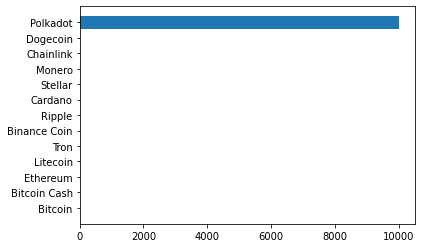

In [24]:
#monte carlo
y = [i*10000 for i in list(opt_results.x)]
x = list(tickers.keys())
plt.barh(x,y)

<BarContainer object of 13 artists>

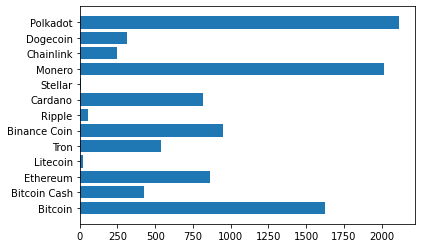

In [31]:
#optimization
y = [i*10000 for i in list(best_weights[max_index])]
x = list(tickers.keys())
plt.barh(x,y)

### Efficient Frontier

In [26]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [29]:
frontier_y = np.linspace(0, 0.6, 50)
frontier_volatility = []

for possible_return in frontier_y:
    constraints = ({'type':'eq', 'fun': check_sum}, 
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, x0,  method='SLSQP', 
                       bounds=bounds, constraints=constraints)
    frontier_volatility.append(result['fun'])

Text(0.5, 1.0, 'Efficient Frontier')

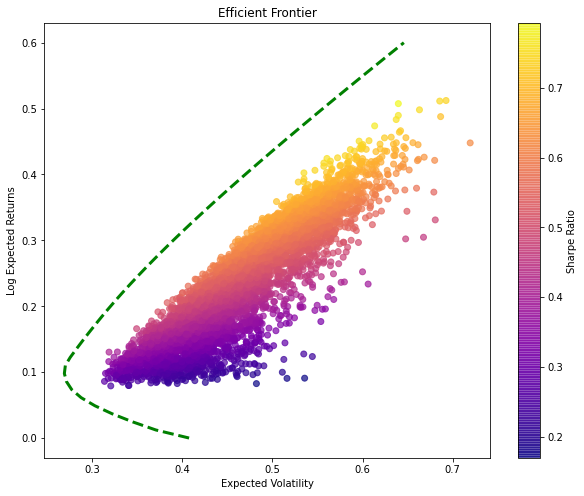

In [30]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=.7)
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(vol_arr[max_index], 
#             ret_arr[max_index], c='red', s=50, edgecolors='black', label='Max SR')
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)

plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.title('Efficient Frontier')